In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import socket
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error:
    raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai icrawler

In [4]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

In [5]:
def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name}, 
    )
    crawler.crawl(keyword=term, max_num=max_images)

In [6]:
search_images("carabao", 1)

Searching for 'carabao'


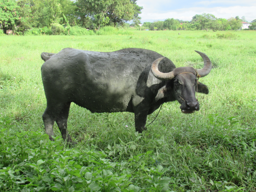

In [7]:
from fastai.vision.all import *
im = Image.open("carabao000001.png")
# icrawler names the downloaded photos from 000001 to 999999
im.to_thumb(256,256)

In [8]:
search_images("cow", 1)

Searching for 'cow'


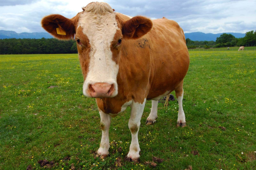

In [9]:
im = Image.open("cow000001.png")
im.to_thumb(256,256)

In [10]:

## !! IMPORTANT
# This represents the number of photos that'll be downloaded for each category.
# If you don't want to wait you can lower this number so less images will be downloaded.
# Having less images to train on may lead to worse neural network performance.
no_of_photos = 20 # Default is 20

searches = 'cow','carabao'
path = Path('carabao_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    search_images(f"{o} photo", no_of_photos, dest)
    sleep(10)  # Pause between searches to avoid over-loading server
    search_images(f"{o} sun photo", no_of_photos, dest)
    sleep(10)
    search_images(f"{o} night photo", no_of_photos, dest) 
    # Changed this to get "night photo" instead of "shade photo" since the original would cause paint tones to be downloaded 
    sleep(10)
    print(f"Photos of {o} completed!")

resize_images(path, max_size=400, dest=path, recurse=True)
print(f"Photos resized!")

Searching for 'cow photo'
Searching for 'cow sun photo'
Searching for 'cow night photo'
Photos of cow completed!
Searching for 'carabao photo'
Searching for 'carabao sun photo'
Searching for 'carabao night photo'
Photos of carabao completed!


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Photos resized!


In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

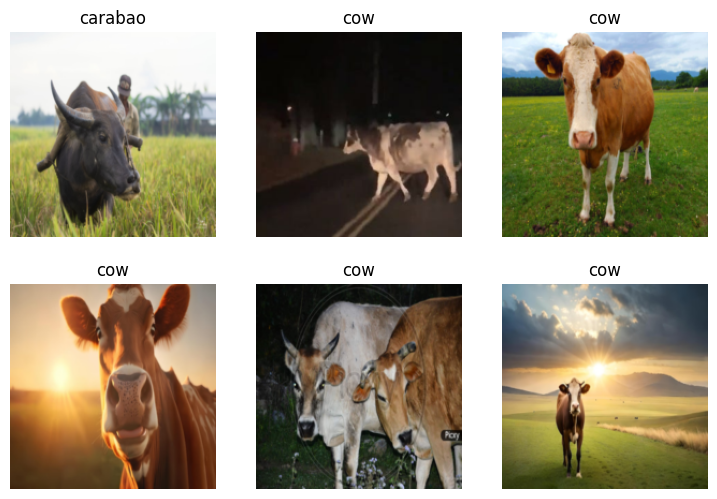

In [23]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.6MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.294104,0.781367,0.375000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.696187,0.456339,0.166667,00:12
1,0.413136,0.186206,0.041667,00:12
2,0.280186,0.138172,0.041667,00:11


In [14]:
is_carabao,_,probs = learn.predict(PILImage.create('carabao000001.png'))
print(f"This is a: {is_carabao}.")
print(f"Probability it's a carabao: {probs[0]:.4f}")

This is a: carabao.
Probability it's a carabao: 0.9987
